<a href="https://colab.research.google.com/github/Chandramani05/Hunting-for-Exoplanet-in-Deep-Space/blob/main/MSML_603_Final_Project_Hunting_the_Exoplanets_in_the_Deep_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparing the Environment and Loading the Data

In [22]:
import operator
import itertools
import numpy as np
import pandas as pd
import missingno as mn
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats import weightstats as ws
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

###Uploading the DataSet 
NASA Cumulative Data 
Link : https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative

*It contains 9564 rows with 141 features*

In [23]:
df_exoplanet_full = pd.read_csv('/content/drive/MyDrive/dataset_exoplanets_29.07.2022_ready.csv')
df_exoplanet_full

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_time0,koi_time0_err1,koi_time0_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,...,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_model_dof,koi_model_chisq,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sage,koi_sage_err1,koi_sage_err2,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,2455003.539,0.002160,-0.002160,0.0,NaN,NaN,NaN,NaN,NaN,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,NaN,NaN,NaN,615.8,19.5,-19.5,0.022344,0.000832,-0.000528,3.20796,0.33173,-1.09986,LS+MCMC,2.26,0.26,-0.15,0.0853,NaN,NaN,89.66,NaN,NaN,793.0,NaN,NaN,93.59,29.45,-16.65,24.810,2.600,-2.600,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,...,0.4603,q1_q17_dr25_koi,5.135849,28.470820,35.8,2,142.0,1.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.6864,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-001-2016...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,NaN,NaN,NaN,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,1.400000e-05,48.141910,0.000130,0.430,0.510,0.940,0.480,-0.000200,0.000320,-0.000550,0.000310,-0.010,0.130,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,2454995.514,0.003520,-0.003520,0.0,NaN,NaN,NaN,NaN,NaN,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,NaN,NaN,NaN,874.8,35.5,-35.5,0.027954,0.009078,-0.001347,3.02368,2.20489,-2.49638,LS+MCMC,2.83,0.32,-0.19,0.2734,NaN,NaN,89.57,NaN,NaN,443.0,NaN,NaN,9.11,2.87,-1.62,77.900,28.400,-28.400,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,...,0.4603,q1_q17_dr25_koi,7.027669,20.109507,25.8,2,25.0,2.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.0023,Mandel and Agol (2002 ApJ 580 171),NaN,NaN,010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-002-2016...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,NaN,NaN,NaN,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006

##Data Selection and DataSet Assembly for Training



##Dropping the unnecessary columns

First let's take a look at the missing values as a barplot with the MissingNo library.

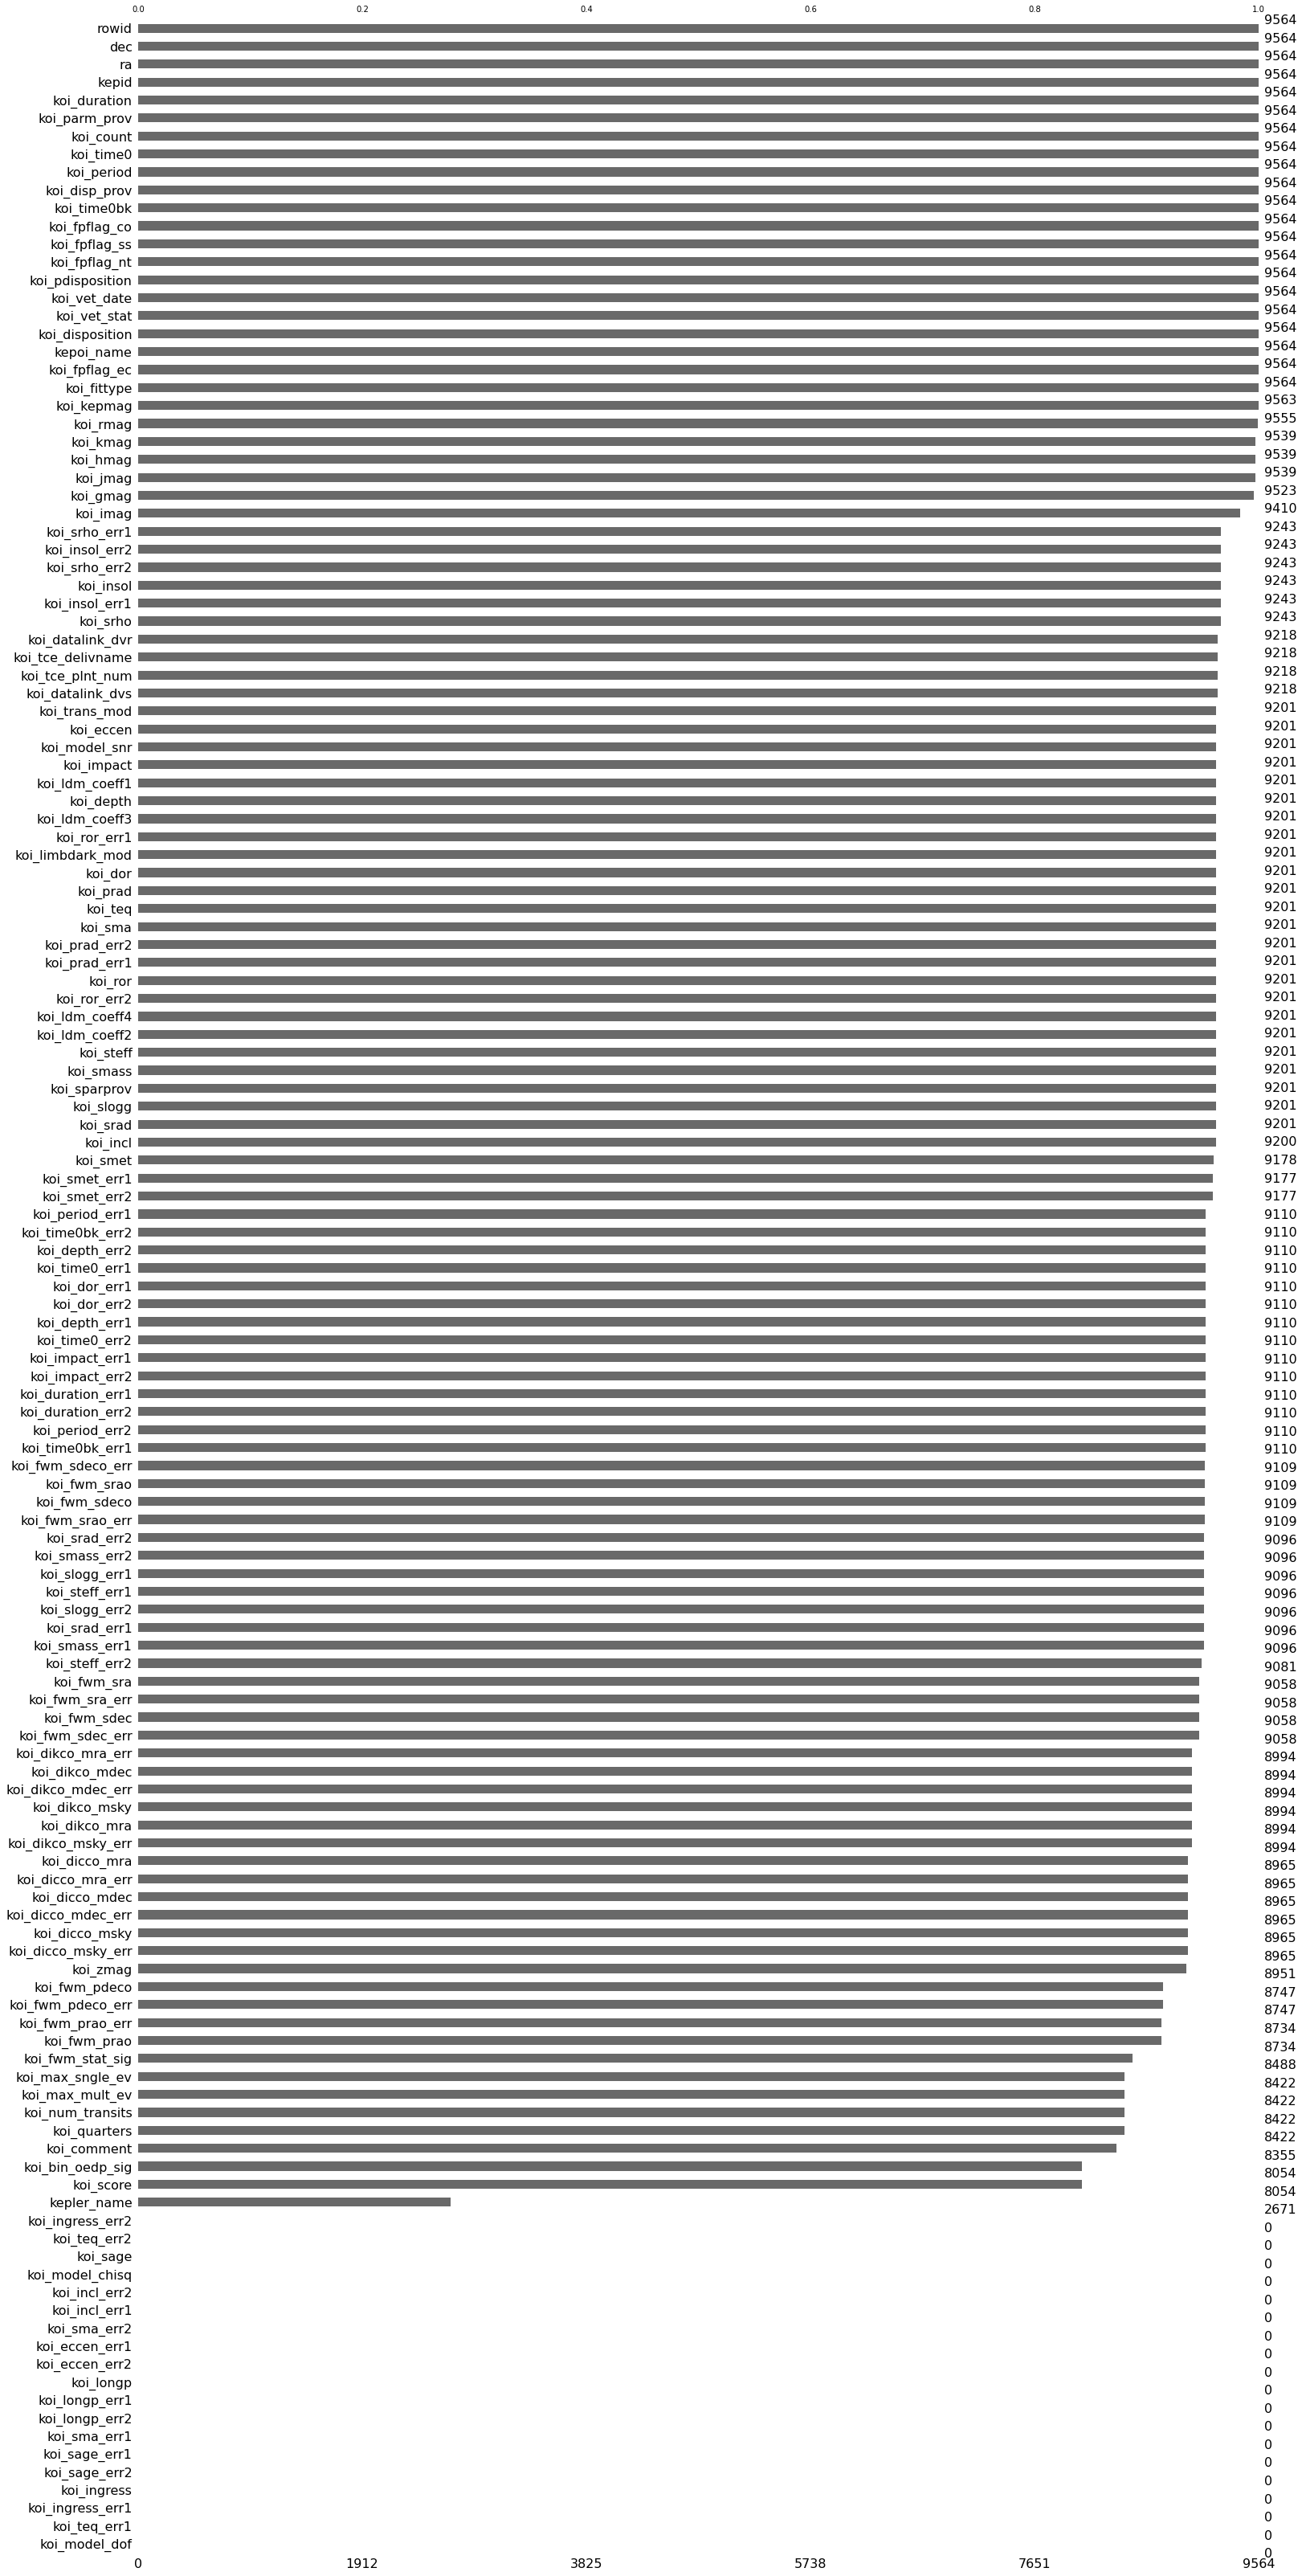

In [24]:
mn.bar(df_exoplanet_full[df_exoplanet_full.isnull().sum().sort_values(ascending=False).index])

Let's first remove all the columns that have all missing values and also the 'kepler_name' column since it's mostly missing values and it doesn't provide any useful info on the disposition anyways. In addition, we'll also remove the column 'koi_time0' and it's corresponding error measurements since it is the same measurement as 'koi_time0bk' just in different units.

In [25]:
# dropping columns with 0 non-null entries
nan_columns = [column for column in df_exoplanet_full.columns if df_exoplanet_full[column].isnull().all()]
df_exoplanet_data = df_exoplanet_full.drop(columns=nan_columns+['kepler_name']+['koi_time0']+['koi_time0_err1']+['koi_time0_err2'])

In [26]:
pd.set_option('display.max_columns', 140)
df_exoplanet_data.head()

,rowid,kepid,kepoi_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_incl,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,0.022344,0.000832,-0.000528,3.20796,0.33173,-1.09986,LS+MCMC,2.26,0.26,-0.15,0.0853,89.66,793.0,93.59,29.45,-16.65,24.810,2.600,-2.600,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,q1_q17_dr25_koi,5.135849,28.470820,35.8,2,142.0,1.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.6864,Mandel and Agol (2002 ApJ 580 171),010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-001-2016...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,1.400000e-05,48.14191,0.000130,0.430,0.510,0.940,0.480,-0.00020,0.00032,-0.00055,0.00031,-0.010,0.130,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,0.027954,0.009078,-0.001347,3.02368,2.20489,-2.49638,LS+MCMC,2.83,0.32,-0.19,0.2734,89.57,443.0,9.11,2.87,-1.62,77.900,28.400,-28.400,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,q1_q17_dr25_koi,7.027669,20.109507,25.8,2,25.0,2.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.0023,Mandel and Agol (2002 ApJ 580 171),010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-002-2016...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.462265,2.000000e-05,48.14199,0.000190,-0.630,0.720,1.230,0.680,0.00066,0.00065,-0.00105,0.00063,0.390,0.360,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,0,0,q1_q17_dr25_sup_koi,DEEP_V_SHAPED,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,0.154046,5.034292,-0.042179,7.29555,35.03293,-2.75453,LS+MCMC,14.60,3.92,-1.31,0.1419,88.96,638.0,39.

###Finding columns containign only 0 or null values and dropping them

###Removing rrelevant attributes - 'rowid', 'kepid', 'kepoi_name', 'kepler_name'. These attributes are identification and do not represent information in the model

In [27]:
df_exoplanet_data.drop(['rowid', 'kepid', 'kepoi_name'],axis=1,inplace=True)
df_exoplanet_data

,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_incl,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,0.022344,0.000832,-0.000528,3.20796,0.33173,-1.09986,LS+MCMC,2.26,0.26,-0.15,0.0853,89.66,793.0,93.59,29.45,-16.65,24.810,2.600,-2.600,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,q1_q17_dr25_koi,5.135849,28.470820,35.8,2,142.0,1.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.6864,Mandel and Agol (2002 ApJ 580 171),010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-001-2016...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,1.400000e-05,48.141910,0.000130,0.430,0.510,0.940,0.480,-0.000200,0.000320,-0.000550,0.000310,-0.010,0.130,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,0,0,q1_q17_dr25_sup_koi,NO_COMMENT,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,0.027954,0.009078,-0.001347,3.02368,2.20489,-2.49638,LS+MCMC,2.83,0.32,-0.19,0.2734,89.57,443.0,9.11,2.87,-1.62,77.900,28.400,-28.400,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,q1_q17_dr25_koi,7.027669,20.109507,25.8,2,25.0,2.0,q1_q17_dr25_tce,11111111111111111000000000000000,0.0023,Mandel and Agol (2002 ApJ 580 171),010/010797/010797460/dv/kplr010797460-20160209...,010/010797/010797460/dv/kplr010797460-002-2016...,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,q1_q17_dr25_stellar,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.462265,2.000000e-05,48.141990,0.000190,-0.630,0.720,1.230,0.680,0.000660,0.000650,-0.001050,0.000630,0.390,0.360,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,0,0,q1_q17_dr25_sup_koi,DEEP_V_SHAPED,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,0.154046,5.034292,-0.042179,7.29555,35.03293,-2.75453,LS+MCMC,14.60,3.92,-1.31,0.1419,88.96,638.0,39.30,31.04,-10.49,53.500,25.700,-25.700,Claret (2011 A&A 529 75) ATLAS LS,0.0,

**The koi_disposition attribute is the target**
**It presents 3 possibilities: FALSE POSITIVE**, **CONFIRMED and CANDIDATE**.

 1. FALSE POSITIVE - Confirmed by other methods.
 2. CONFIRMED - Confirmed as an exoplanet
 3. CANDIDATE - Still under evaluation

**The base will be separated into two sets**:
 1. FALSE POSITIVE + CONFIRMED
 2. CANDIDATE

*The first base will be used for training and testing*
*The candidate base can be used to verify which *objects *of interest would be confirmed as planets using the model*.

**There are 38 attributes selected from the original dataset - lists of categories of these attributes have been created for future use**

In [28]:
#df_exoplanets_columns
exoplanet_archeive_information = ['koi_disposition', 'koi_pdisposition']
project_disposition_columns = ['koi_score','koi_fpflag_nt', 'koi_fpflag_ss','koi_fpflag_co', 'koi_fpflag_ec']
transit_properties = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_ldm_coeff2', 'koi_ldm_coeff1']
tce_event_information = ['koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 'koi_num_transits']
stellar_parameters = ['koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass']
kic_parameters = ['ra', 'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag']

categories = [exoplanet_archeive_information, project_disposition_columns, transit_properties, tce_event_information, stellar_parameters, kic_parameters]

#Test Parameters

y_feature = ['koi_disposition', 'koi_pdisposition']
features = ['koi_score','koi_fpflag_nt', 'koi_fpflag_ss','koi_fpflag_co', 'koi_fpflag_ec','koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_ldm_coeff2', 'koi_ldm_coeff1','koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 'koi_num_transits','koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass','ra', 'dec', 'koi_kepmag', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag']

y_feature

['koi_disposition', 'koi_pdisposition']

#Pre-Processing, Preliminary Analysis of Outliers and Null/Empty Data

##Dataset Balance Analysis

In [29]:
df_exoplanet_data.assign(n=0).groupby(['koi_pdisposition']).n.count()

koi_pdisposition
CANDIDATE         4717
FALSE POSITIVE    4847
Name: n, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


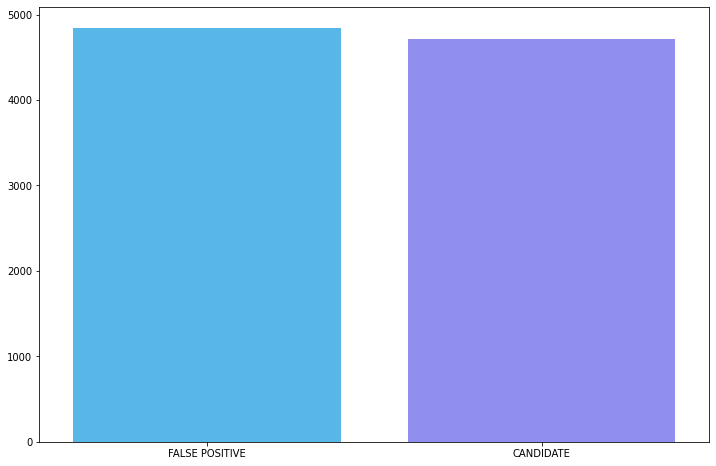

In [30]:
 #Evaluating the balance of the datasets

fig, ax = plt.subplots(figsize = (12,8))
with sns.color_palette("cool", 3):
    sns.barplot(df_exoplanet_data['koi_pdisposition'].value_counts().index, df_exoplanet_data['koi_pdisposition'].value_counts().values)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


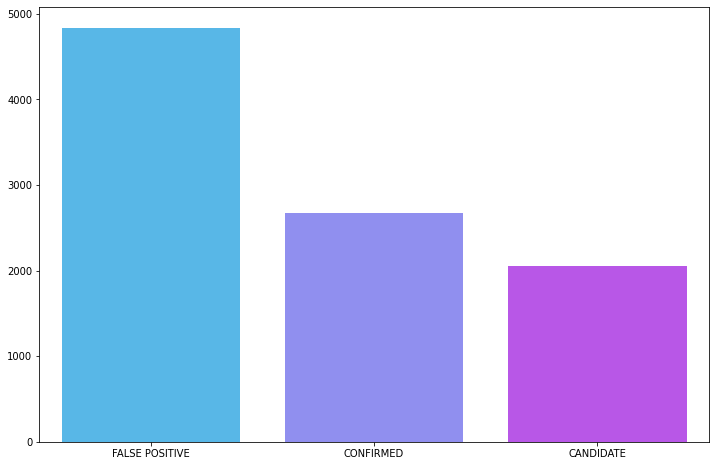

In [31]:
fig, ax = plt.subplots(figsize = (12,8))
with sns.color_palette("cool", 3):
        sns.barplot(df_exoplanet_data['koi_disposition'].value_counts().index, df_exoplanet_data['koi_disposition'].value_counts().values)

###Null and/or Void Data Analysis and Preliminary Outlier Analysis
Need to fill the Null values ​​in the attributes or check if there is relevance in it.

In [32]:
df_exoplanet_data.isna().any()

koi_disposition       False
koi_vet_stat          False
koi_vet_date          False
koi_pdisposition      False
koi_score              True
                      ...  
koi_dikco_mra_err      True
koi_dikco_mdec         True
koi_dikco_mdec_err     True
koi_dikco_msky         True
koi_dikco_msky_err     True
Length: 115, dtype: bool

###Analsing Attribute koi_score

In [33]:
print("Sum of all null values in koi _score = " + str(df_exoplanet_data.koi_score.isna().sum()))
print(df_exoplanet_data.koi_score.describe())
##Filling the N/A values with 0 as he koi_score is the confidence against the record class. Filling of null values ​​will be according to the worst case.
df_exoplanet_data.koi_score.fillna(0,inplace=True)
print("Sum of all null values in koi _score = " + str(df_exoplanet_data.koi_score.isna().sum()))

Sum of all null values in koi _score = 1510
count    8054.000000
mean        0.480829
std         0.476928
min         0.000000
25%         0.000000
50%         0.334000
75%         0.998000
max         1.000000
Name: koi_score, dtype: float64
Sum of all null values in koi _score = 0


### koi_impact attribute with Outliers values

count    9201.000000
mean        0.735105
std         3.348832
min         0.000000
25%         0.197000
50%         0.537000
75%         0.889000
max       100.806000
Name: koi_impact, dtype: float64


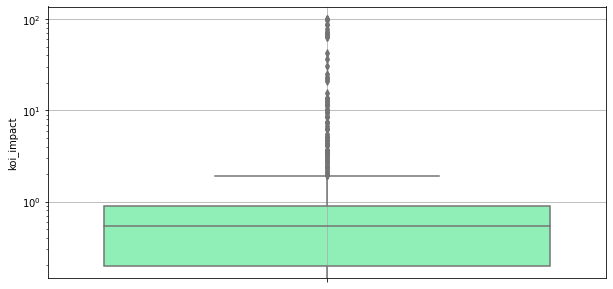

No of Null Values: 0


In [34]:
print(df_exoplanet_data.koi_impact.describe())


fig, ax= plt.subplots(figsize=(10, 5))
ax.set_yscale('log')
g = sns.boxplot(y=df_exoplanet_data["koi_impact"],palette='rainbow', ax = ax)
plt.grid()
plt.show()
# Inserted Average Values
df_exoplanet_data.koi_impact.fillna(df_exoplanet_data.koi_impact.mean(), inplace=True)
print('No of Null Values: ' + str(df_exoplanet_data.koi_impact.isna().sum()))
# For now Outliers held if any significance

### Exploratory analysis of the exoplanet_archive_information CategoryAttributes present in this category


##Data Visualization

In [35]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

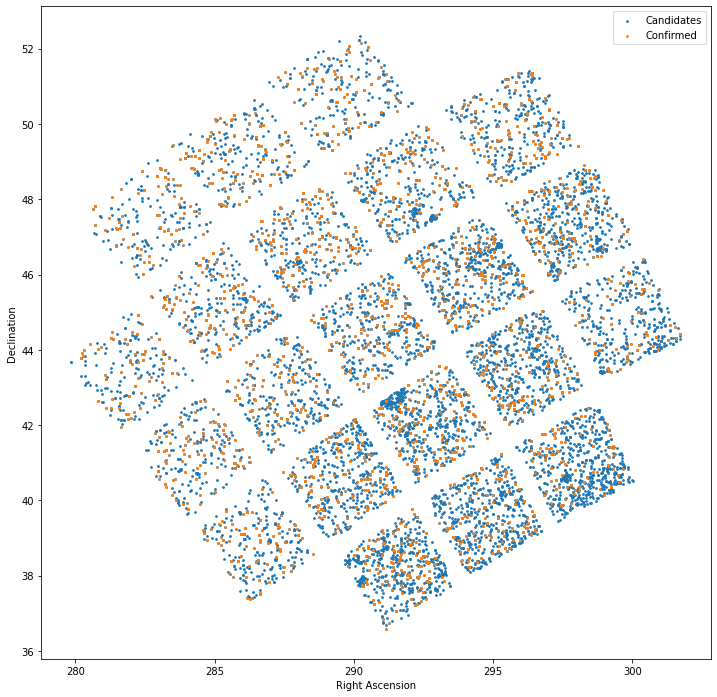

In [36]:
confirmed = df_exoplanet_data[df_exoplanet_data.koi_disposition == 'CONFIRMED']

ra, dec = df_exoplanet_data.ra, df_exoplanet_data.dec
ra_c, dec_c = confirmed.ra, confirmed.dec

fig = plt.figure(figsize=(12, 12))

plt.scatter(ra, dec, s=3, label='Candidates')
plt.scatter(ra_c, dec_c, s=3, label="Confirmed")

plt.xlabel("Right Ascension")
plt.ylabel("Declination")

plt.legend()

Closer to the Milky Way's bulge, or to the side, the density of stars rises.

It's also interesting to notice that the density of the number of confirmed planets does not rise as the arrangement of stars in space gets denser (near to the Milky Way's arm's core). This is most likely caused by how challenging it is to conduct observations in a denser region of space.

Text(0.5, 0, 'Orbital period of confirmed planets, (days)')

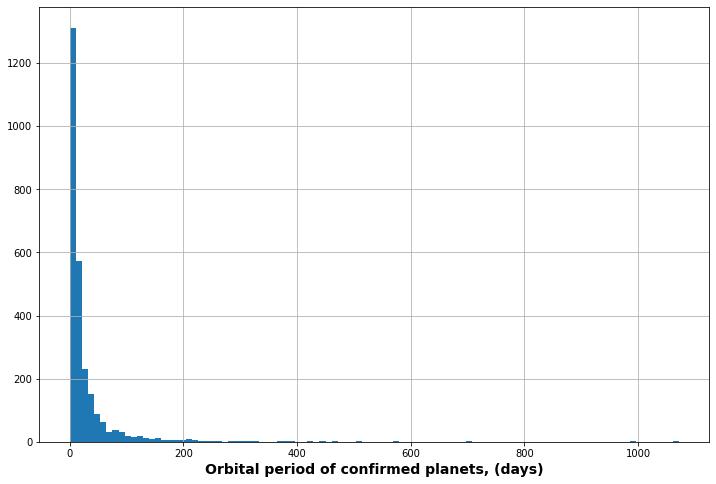

In [37]:
ax = confirmed.koi_period.hist(bins=100, figsize=(12, 8))
ax.set_xlabel("Orbital period of confirmed planets, (days)", fontdict= {'size' : '14', 'weight' : 'bold'})

From above graph we see that most of the confirmed planets have lower orbital periods. This makes sense, since the lower the orbital period, the more likely it will be to eclipse it's star (and therefore the more likely it will be observed)

Text(0.5, 1.0, 'Surface gravity of stars with confirmed planets')

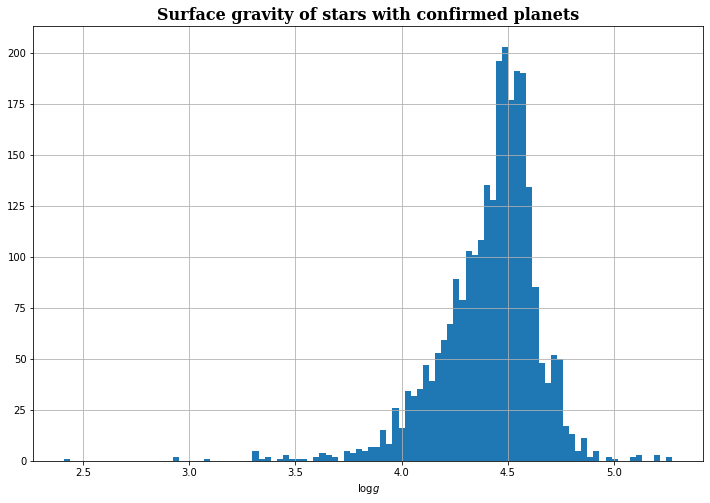

In [38]:
ax = confirmed.koi_slogg.hist(bins=100, figsize=(12, 8))
ax.set_xlabel("$\log{g}$")
ax.set_title("Surface gravity of stars with confirmed planets", font)

Text(0.5, 1.0, 'Сonfirmed')

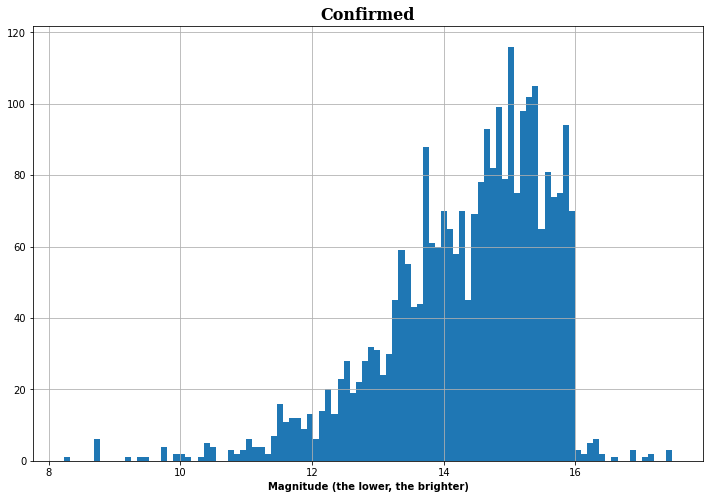

In [39]:
ax = confirmed.koi_kepmag.hist(bins=100, figsize=(12, 8))
ax.set_xlabel("Magnitude (the lower, the brighter)", fontdict = {'weight' : 'bold'})
ax.set_title("Сonfirmed", font)

We see a sharp decline around the 16th magnitude. This seems to be the limit at which the noise gets too much to detect planetary candidates.

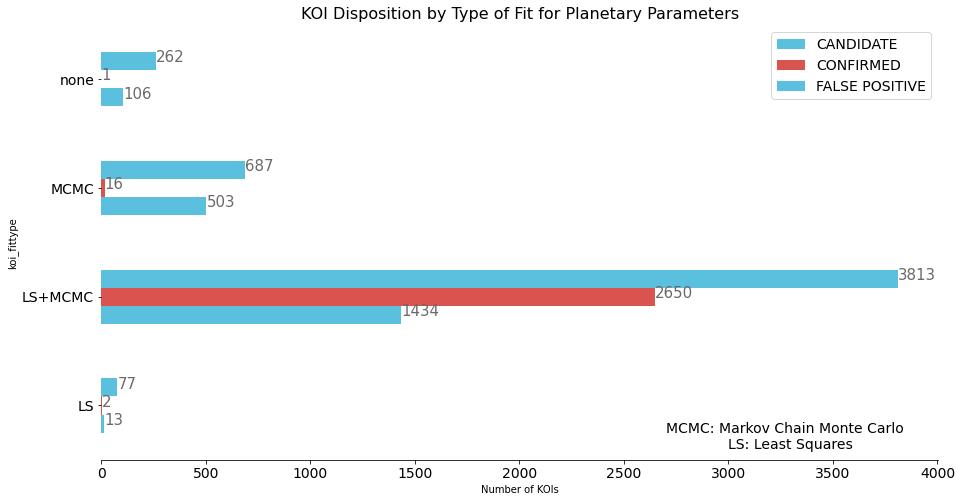

In [40]:
ax = df_exoplanet_data.groupby(['koi_disposition'])['koi_fittype'].value_counts().unstack(0).plot.barh(figsize=(15,8),
                                                                                   width=0.5,
                                                                                   color=['#5bc0de', '#d9534f'],
                                                                                   fontsize=14)
ax.annotate('MCMC: Markov Chain Monte Carlo', xy=(10, 0), xytext=(2700, -.25), size=14)
ax.annotate('LS: Least Squares', xy=(10, 0), xytext=(3000, -.4), size=14)
plt.legend(fontsize=14)
plt.title("KOI Disposition by Type of Fit for Planetary Parameters",
         fontsize=16)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_width(), i.get_y()+.075, \
            str(int(i.get_width())), fontsize=15,
                color='dimgrey', clip_on=True)

ax.set_xlabel('Number of KOIs')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)


Looks like KOIs where the fit type Least Squares was used are all classified as 'FALSE POSITIVE' , and less than 0.47% of KOIs not using any fit and 2.0% of KOIs with using the Markov Chain Monte Carlo fit are classified as 'CONFIRMED'. Let's binarize the 'fittype' feature to create a new column 'LS+MCMC' where it is 1 if LS+MCMC is used and 0 if not.

### **There are 2 options for further research**.


*   We choose koi_pdisposition as the target variable and train our model to recognize the most probable CANDIDATE objects
*   We choose koi_disposition as the target variable and train our model to recognize the most likely CONFIRMED objects.


Since the share of error between CANDIDATE and CONFIRMED is quite small (45 / (2293 + 45)) x100% = 1.92%, we have decided to choose option 1. After all, assignment of the CONFIRMED status.

So, we will classify objects only as either CANDIDATE or FALSE POSITIVE.

In [41]:
# Now we will recode categorical features for further analysis

# Let's write a function that accepts DataFrame as input, encode categorical features with numeric values and returns the updated DataFrame and the encoders themselves.

def nef(init_df):
    result = init_df.copy() # copy of our original table
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # if the column type is a string, then it is encoded
            encoders[column] = LabelEncoder() # creating an encoder for the column
            result[column] = encoders[column].fit_transform(result[column]) # apply the encoder to the column and overwrite the column
    return result, encoders

df_encoded, encoders = nef(df_exoplanet_data) # Now encoded data contains encoded categorical signs 
df_encoded.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_incl,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,0,0,0,1.000,0,0,0,0,0,756,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,0.022344,0.000832,-0.000528,3.20796,0.33173,-1.09986,1,2.26,0.26,-0.15,0.0853,89.66,793.0,93.59,29.45,-16.65,24.810,2.600,-2.600,0,0.0,0.0,0.2291,0.4603,2,5.135849,28.470820,35.8,2,142.0,1.0,2,211,0.6864,0,6968,7949,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,1,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,1.400000e-05,48.14191,0.000130,0.430,0.510,0.940,0.480,-0.00020,0.00032,-0.00055,0.00031,-0.010,0.130,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,1,0,0,0,0.969,0,0,0,0,0,756,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,0.027954,0.009078,-0.001347,3.02368,2.20489,-2.49638,1,2.83,0.32,-0.19,0.2734,89.57,443.0,9.11,2.87,-1.62,77.900,28.400,-28.400,0,0.0,0.0,0.2291,0.4603,2,7.027669,20.109507,25.8,2,25.0,2.0,2,211,0.0023,0,6968,7950,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,1,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.462265,2.000000e-05,48.14199,0.000190,-0.630,0.720,1.230,0.680,0.00066,0.00065,-0.00105,0.00063,0.390,0.360,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,0,0,0,0,0.000,0,0,0,0,0,62,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,0.154046,5.034292,-0.042179,7.29555,35.03293,-2.75453,1,14.60,3.92,-1.31,0.1419,88.96,638.0,39.30,31.04,-10.49,53.500,25.700,-25.700,0,0.0,0.0,0.2711,0.3858,2,37.159767,187.449100,76.3,1,56.0,1.0,2,200,0.6624,0,6982,7964,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.30,-0.30,0.868,0.233,-0.078,0.961,0.110,-0.121,1,297.00482,48.134129,15.436,15.943,15.390,15.220,15.166,14.254,13.900,13.826,0.278,19.800321,1.900000e-06,48.13412,0.000020,-0.021,0.069,-0.038,0.071,0.00070,0.00240,0.00060,0.00340,-0.025,0.070,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,2,0,0,1,0.000,0,1,0,0,0,459,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,0.387394,0.109232,-0.084950,0.22080,0.00917,-0.01837,1,33.46,8.50,-2.83,0.0267,67.09,13

##Corelation Matrix

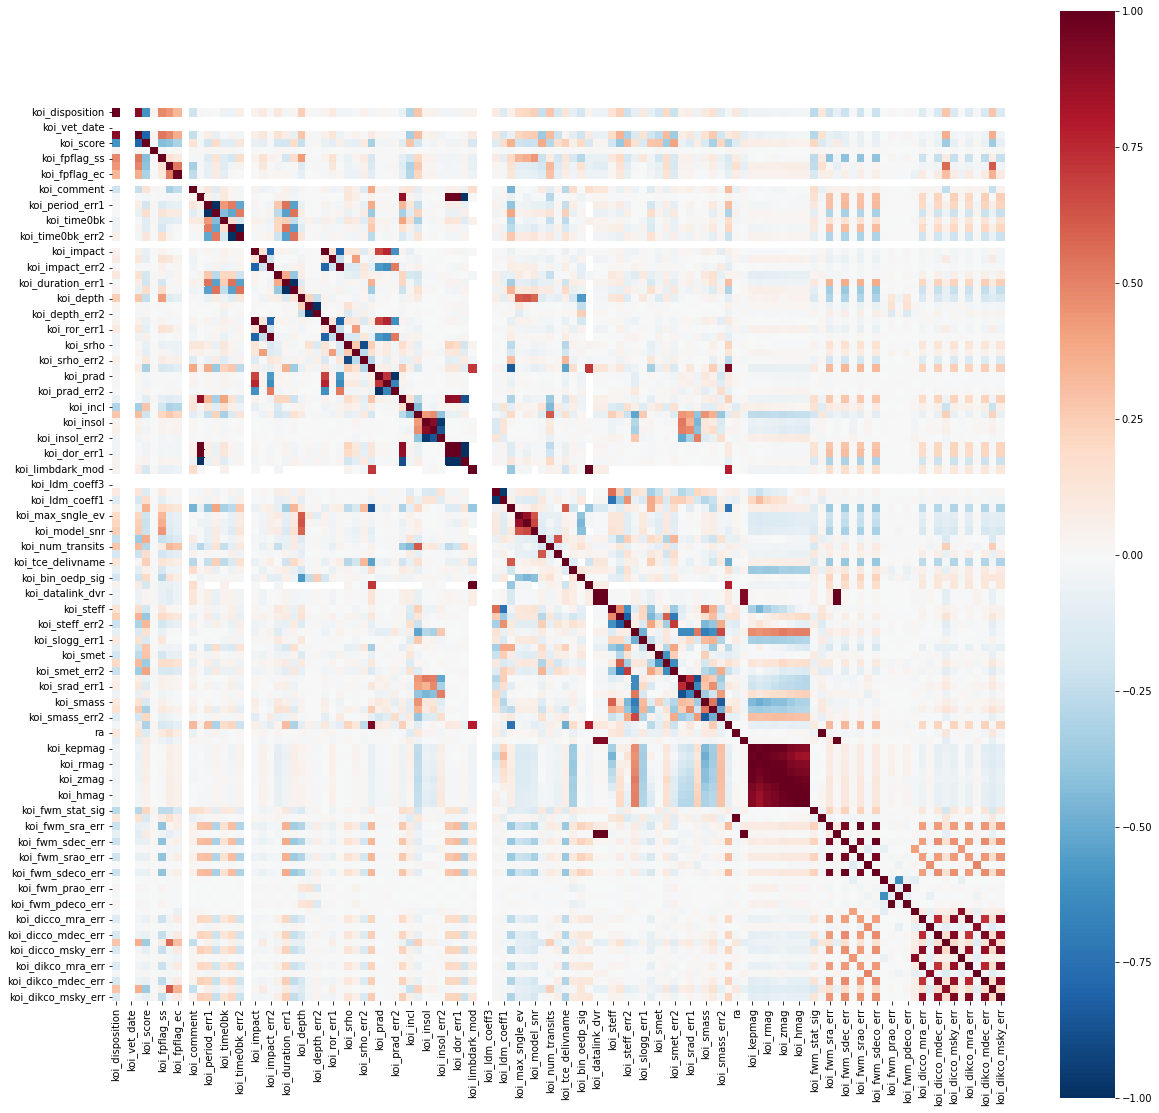

In [42]:
plt.subplots(figsize=(20,20))
sns.heatmap(df_encoded.corr(), square=True, cmap="RdBu_r")
plt.show()

From the correlation matrix, it can be seen that kepid is fully correlated with dec.

dec is the KIC (Kepler Input Catalog) Declination -

Kepler Input Catalog: Photometric Calibration and Star Classification.

So, we conclude that KepId tells us the type of star we are observing

In [43]:
df_encoded.drop(['koi_teq_err1', 'koi_teq_err2'], 1, errors='ignore', inplace = True)
df_encoded

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_incl,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,0,0,0,1.000,0,0,0,0,0,756,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,0.022344,0.000832,-0.000528,3.20796,0.33173,-1.09986,1,2.26,0.26,-0.15,0.0853,89.66,793.0,93.59,29.45,-16.65,24.810,2.600,-2.600,0,0.0,0.0,0.2291,0.4603,2,5.135849,28.470820,35.8,2,142.0,1.0,2,211,0.6864,0,6968,7949,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,1,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,1.400000e-05,48.141910,0.000130,0.430,0.510,0.940,0.480,-0.000200,0.000320,-0.000550,0.000310,-0.010,0.130,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,1,0,0,0,0.969,0,0,0,0,0,756,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,0.027954,0.009078,-0.001347,3.02368,2.20489,-2.49638,1,2.83,0.32,-0.19,0.2734,89.57,443.0,9.11,2.87,-1.62,77.900,28.400,-28.400,0,0.0,0.0,0.2291,0.4603,2,7.027669,20.109507,25.8,2,25.0,2.0,2,211,0.0023,0,6968,7950,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,1,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.462265,2.000000e-05,48.141990,0.000190,-0.630,0.720,1.230,0.680,0.000660,0.000650,-0.001050,0.000630,0.390,0.360,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,0,0,0,0,0.000,0,0,0,0,0,62,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,0.154046,5.034292,-0.042179,7.29555,35.03293,-2.75453,1,14.60,3.92,-1.31,0.1419,88.96,638.0,39.30,31.04,-10.49,53.500,25.700,-25.700,0,0.0,0.0,0.2711,0.3858,2,37.159767,187.449100,76.3,1,56.0,1.0,2,200,0.6624,0,6982,7964,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.30,-0.30,0.868,0.233,-0.078,0.961,0.110,-0.121,1,297.00482,48.134129,15.436,15.943,15.390,15.220,15.166,14.254,13.900,13.826,0.278,19.800321,1.900000e-06,48.134120,0.000020,-0.021,0.069,-0.038,0.071,0.000700,0.002400,0.000600,0.003400,-0.025,0.070,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,2,0,0,1,0.000,0,1,0,0,0,459,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,0.387394,0.109232,-0.084950,0.22080,0.00917,-0.01837,1,33.46,8.50,-2.83,

We can also remove the koi_disposition parameter (since we decided to use koi_pdisposition earlier).

In addition, the koi_pdisposition and koi_disposition data are highly correlated with each other.

Also, we can safely remove the rowid and kepoi_name columns ( they are just column numbers and object names).

In [44]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Columns: 115 entries, koi_disposition to koi_dikco_msky_err
dtypes: float64(95), int64(20)
memory usage: 8.4 MB


In [45]:
df_encoded.drop(['koi_disposition'], 1, errors='ignore', inplace = True)
df_encoded

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_incl,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,0,0,0,1.000,0,0,0,0,0,756,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,0.022344,0.000832,-0.000528,3.20796,0.33173,-1.09986,1,2.26,0.26,-0.15,0.0853,89.66,793.0,93.59,29.45,-16.65,24.810,2.600,-2.600,0,0.0,0.0,0.2291,0.4603,2,5.135849,28.470820,35.8,2,142.0,1.0,2,211,0.6864,0,6968,7949,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,1,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,1.400000e-05,48.141910,0.000130,0.430,0.510,0.940,0.480,-0.000200,0.000320,-0.000550,0.000310,-0.010,0.130,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,0,0,0,0.969,0,0,0,0,0,756,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,0.027954,0.009078,-0.001347,3.02368,2.20489,-2.49638,1,2.83,0.32,-0.19,0.2734,89.57,443.0,9.11,2.87,-1.62,77.900,28.400,-28.400,0,0.0,0.0,0.2291,0.4603,2,7.027669,20.109507,25.8,2,25.0,2.0,2,211,0.0023,0,6968,7950,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,1,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.462265,2.000000e-05,48.141990,0.000190,-0.630,0.720,1.230,0.680,0.000660,0.000650,-0.001050,0.000630,0.390,0.360,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,0,0,0,0.000,0,0,0,0,0,62,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,0.154046,5.034292,-0.042179,7.29555,35.03293,-2.75453,1,14.60,3.92,-1.31,0.1419,88.96,638.0,39.30,31.04,-10.49,53.500,25.700,-25.700,0,0.0,0.0,0.2711,0.3858,2,37.159767,187.449100,76.3,1,56.0,1.0,2,200,0.6624,0,6982,7964,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.30,-0.30,0.868,0.233,-0.078,0.961,0.110,-0.121,1,297.00482,48.134129,15.436,15.943,15.390,15.220,15.166,14.254,13.900,13.826,0.278,19.800321,1.900000e-06,48.134120,0.000020,-0.021,0.069,-0.038,0.071,0.000700,0.002400,0.000600,0.003400,-0.025,0.070,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,0,0,1,0.000,0,1,0,0,0,459,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,0.387394,0.109232,-0.084950,0.22080,0.00917,-0.01837,1,33.46,8.50,-2.83,0.0267,67.09,1395.0,891.

##Distribution of Values By Features

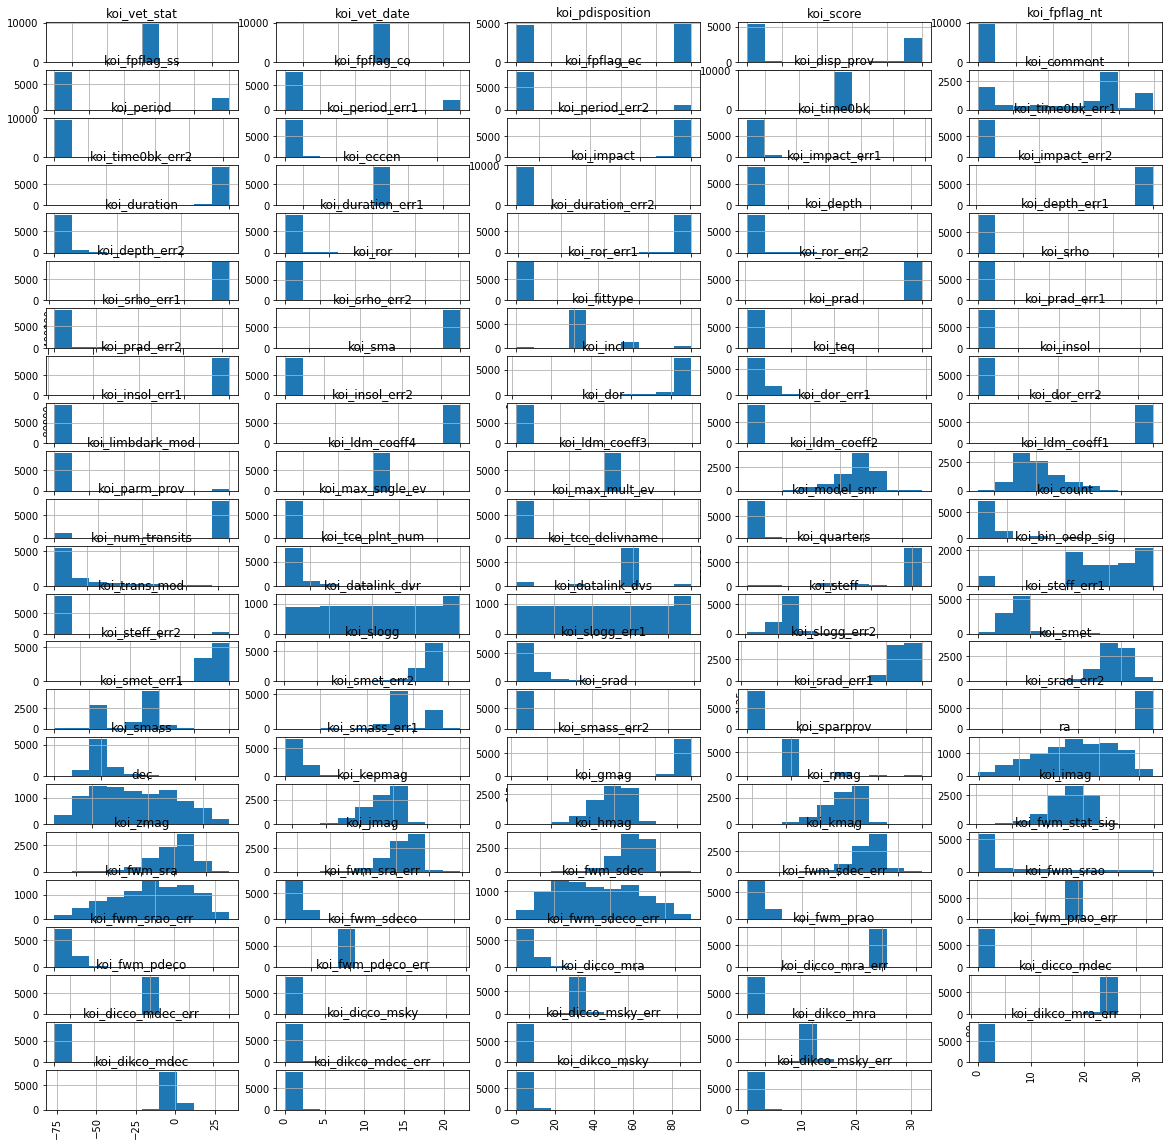

In [46]:
fig = plt.figure(figsize=(20,20))
cols = 5

rows = np.ceil(float(df_encoded.shape[1]) / cols)
for i, column in enumerate(df_encoded.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    df_encoded[column].hist(axes=ax)
    plt.xticks(rotation="vertical")

##Gaps in Dataset

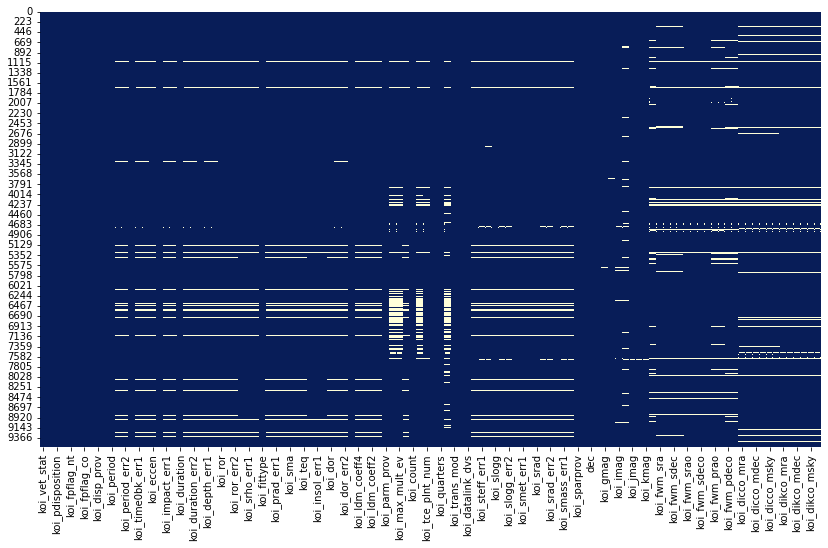

In [47]:
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(df_encoded.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

##Encoding the target class into binary

In [48]:
enc1 = encoders['koi_pdisposition'].transform(['FALSE POSITIVE'])
enc2 = encoders['koi_pdisposition'].transform(['CANDIDATE'])
print(f'CANDIDATE status is encoded as {enc1}')
print(f'FALSE POSITIVE status is encoded as{enc2}')

CANDIDATE status is encoded as [1]
FALSE POSITIVE status is encoded as[0]


In [49]:
df_encoded.drop('koi_score', 1, errors='ignore', inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [50]:
df_encoded['koi_tce_plnt_num'].unique()

array([ 1.,  2.,  3., nan,  4.,  5.,  6.,  7.,  8.])

We see that many characteristics have missing values.

Most of the omissions are in the koi_score parameter.

As we remember from the description, it is a value between 0 and 1, which indicates the reliability of the Kepler object of interest location.It basically tells us the same thing as the koi_pdisposition. So, it can be removed from the dataset.

koi_tce_plnt_num - exoplanet number, according to the NASA documentation is just an indicator so it can also be excluded.

The other missing characteristics are:

the impact parameter (the distance projected to the sky between the center of the stellar disk and the center of the disk of the planet in conjunction, normalized by the stellar radius),

the transit depth,

the planetary radius,

the insolation flux,

the transit signal-noise,

the photospheric temperature of the star,

and the uncertainty values.

In [51]:
df_encoded.drop('koi_tce_plnt_num', 1, errors='ignore', inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [52]:
df_encoded.drop(['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'], 1, errors='ignore', inplace = True)
df_encoded

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_incl,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sparprov,ra,dec,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,0,0,0,0,756,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,0.022344,0.000832,-0.000528,3.20796,0.33173,-1.09986,1,2.26,0.26,-0.15,0.0853,89.66,793.0,93.59,29.45,-16.65,24.810,2.600,-2.600,0,0.0,0.0,0.2291,0.4603,2,5.135849,28.470820,35.8,2,142.0,2,211,0.6864,0,6968,7949,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,1,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,1.400000e-05,48.141910,0.000130,0.430,0.510,0.940,0.480,-0.000200,0.000320,-0.000550,0.000310,-0.010,0.130,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,0,0,0,0,756,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,0.027954,0.009078,-0.001347,3.02368,2.20489,-2.49638,1,2.83,0.32,-0.19,0.2734,89.57,443.0,9.11,2.87,-1.62,77.900,28.400,-28.400,0,0.0,0.0,0.2291,0.4603,2,7.027669,20.109507,25.8,2,25.0,2,211,0.0023,0,6968,7950,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,1,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.462265,2.000000e-05,48.141990,0.000190,-0.630,0.720,1.230,0.680,0.000660,0.000650,-0.001050,0.000630,0.390,0.360,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,0,0,0,0,62,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,0.154046,5.034292,-0.042179,7.29555,35.03293,-2.75453,1,14.60,3.92,-1.31,0.1419,88.96,638.0,39.30,31.04,-10.49,53.500,25.700,-25.700,0,0.0,0.0,0.2711,0.3858,2,37.159767,187.449100,76.3,1,56.0,2,200,0.6624,0,6982,7964,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.30,-0.30,0.868,0.233,-0.078,0.961,0.110,-0.121,1,297.00482,48.134129,15.436,15.943,15.390,15.220,15.166,14.254,13.900,13.826,0.278,19.800321,1.900000e-06,48.134120,0.000020,-0.021,0.069,-0.038,0.071,0.000700,0.002400,0.000600,0.003400,-0.025,0.070,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,0,0,1,0,459,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,0.387394,0.109232,-0.084950,0.22080,0.00917,-0.01837,1,33.46,8.50,-2.83,0.0267,67.09,1395.0,891.96,668.95,-230.35,3.278,0.136,-0.136,0,0.0,0.0,0.2865,0.3556,2,39.066550,541.895100,505.6,1,621.0,2,203,0.0000,0,7001,7985,5805.0,157.0,-174.0,4.564,0.

In [53]:
y = np.array(df_encoded['koi_pdisposition'].astype('int64'))
df_encoded.drop('koi_pdisposition', errors='ignore', axis = 1, inplace = True)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Columns: 107 entries, koi_vet_stat to koi_dikco_msky_err
dtypes: float64(93), int64(14)
memory usage: 7.8 MB


##Imputation (Filling the missing values)

In [54]:
# the name of the dataframe columns will be written to the dummies_columns variable
dummies_columns = list(df_encoded.columns)
print(dummies_columns)
percent_missing = df_encoded.isnull().sum() * 100 / len(df_encoded)


['koi_vet_stat', 'koi_vet_date', 'koi_disp_prov', 'koi_comment', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_eccen', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_ror', 'koi_ror_err1', 'koi_ror_err2', 'koi_srho', 'koi_srho_err1', 'koi_srho_err2', 'koi_fittype', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_dor', 'koi_dor_err1', 'koi_dor_err2', 'koi_limbdark_mod', 'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_parm_prov', 'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count', 'koi_num_transits', 'koi_tce_delivname', 'koi_quarters', 'koi_bin_oedp_sig', 'koi_trans_mod', 'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_s

In [55]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()

In [56]:
data_with_imputed_values = my_imputer.fit_transform(df_encoded)
data_with_imputed_values.shape

(9564, 107)

In [57]:
# Let's write the resulting array completely into our dataframe
df_encoded=pd.DataFrame(data_with_imputed_values)
df_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106
0,0.0,0.0,0.0,756.0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.0,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,0.022344,0.000832,-0.000528,3.20796,0.33173,-1.09986,1.0,2.26,0.26,-0.15,0.0853,89.66,793.0,93.59,29.45,-16.65,24.810,2.600,-2.600,0.0,0.0,0.0,0.2291,0.4603,2.0,5.135849,28.470820,35.8,2.0,142.0,2.0,211.0,0.6864,0.0,6968.0,7949.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,1.0,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.462294,1.400000e-05,48.141910,0.000130,0.430,0.510,0.940,0.480,-0.000200,0.000320,-0.000550,0.000310,-0.010,0.130,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,0.0,0.0,0.0,756.0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.0,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,0.027954,0.009078,-0.001347,3.02368,2.20489,-2.49638,1.0,2.83,0.32,-0.19,0.2734,89.57,443.0,9.11,2.87,-1.62,77.900,28.400,-28.400,0.0,0.0,0.0,0.2291,0.4603,2.0,7.027669,20.109507,25.8,2.0,25.0,2.0,211.0,0.0023,0.0,6968.0,7950.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,1.0,291.93423,48.141651,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.462265,2.000000e-05,48.141990,0.000190,-0.630,0.720,1.230,0.680,0.000660,0.000650,-0.001050,0.000630,0.390,0.360,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,0.0,0.0,0.0,62.0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.0,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,0.154046,5.034292,-0.042179,7.29555,35.03293,-2.75453,1.0,14.60,3.92,-1.31,0.1419,88.96,638.0,39.30,31.04,-10.49,53.500,25.700,-25.700,0.0,0.0,0.0,0.2711,0.3858,2.0,37.159767,187.449100,76.3,1.0,56.0,2.0,200.0,0.6624,0.0,6982.0,7964.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,-0.18,0.30,-0.30,0.868,0.233,-0.078,0.961,0.110,-0.121,1.0,297.00482,48.134129,15.436,15.943,15.390,15.220,15.166,14.254,13.900,13.826,0.278,19.800321,1.900000e-06,48.134120,0.000020,-0.021,0.069,-0.038,0.071,0.000700,0.002400,0.000600,0.003400,-0.025,0.070,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,0.0,0.0,0.0,459.0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,0.0,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,0.387394,0.109232,-0.084950,0.22080,0.00917,-0.01837,1.0,33.46,8.50,-2.83,0.0267,67.09,1395.0,891.96,668.95,-230.35,3.278,0.136,-0.136,0.0,0.0,0.0,0.2865,0.3556,2.0,39.066550,541.895100,505.6,1.0,621.0,2.0,203.0,0.0000,0.0,7001.0,7985.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,-0.52,0.30,-0.30,0.791,0.201,-0.067,0.836,0.093,-0.077,1.0,285.53461,48.285210,15.597,16.100,15.554,15.382,15.266,14.326,13.911,13.809,0.000,19.035638,8.600000e-07,48.285210,0.000007,-0.111,0.031,0.002,0.027,0.003020,0.000570,-0.001420,0.000810,-0.249,0.072,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,0.0,0.0,0.0,756.0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.0,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,0.024064,0.003751,-0.001522,1.98635,2.71141,-1.74541,1.0,2.75,0.88,-0.35,0.0374,85.41,1406.0,926.16,874.33,-314.24,8.750,4.000,-4.000,0.0,0.0,0.0,0.2844,0.3661,2.0,4.749945,33.191900,40.9,1.0,515.0,2.0,136.0,0.3090,0.0,7005.0,7989.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,0.07,0.25,-0.30,1.046,0.334,-0.133,1.095,0.151,-0.136,1.0,288.75488,48.226200,15.509,16.015,15.468,15.292,15.241,14.366,14.064,13.952,0.733,19.250326,9.700000e-06,48.226260,0.000100,-0.010,0.350,0.230,0.370,0.000080,0.000200,-0.000070,0.000220,0.030,0.190,-0.090,0.180,0.100,0.140,0.070,0.180,0

In [58]:
# Checking if the data is clean now
missing_val_count_by_column = df_encoded.isnull().sum()
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Series([], dtype: int64)


##Shuffling the Samples

In [59]:
FALSE_POSITIVE = np.argwhere(y == 1).flatten()
print('Number of FALSE POSITIVEs', len(FALSE_POSITIVE))
FALSE_POSITIVE

Number of FALSE POSITIVEs 4847


array([   3,    8,   14, ..., 9559, 9561, 9563])

In [60]:
from sklearn.utils import shuffle

FALSE_POSITIVE = shuffle(FALSE_POSITIVE, random_state = 40)
# find the "extra" ones, for this we cut the found id by the number of CANDIDATE (inside len)
FALSE_POSITIVE = FALSE_POSITIVE[:len(np.argwhere(y == 0).flatten())]
print(len(FALSE_POSITIVE))
# display the number and the id themselves, which we should throw out
FALSE_POSITIVE

4717


array([8906, 4139, 8415, ..., 4953, 4357, 4384])

Checking if datasets are balanced now

In [61]:
len(np.argwhere(y == 0).flatten()) == len(FALSE_POSITIVE)

True

**Creating training dataset X**


In [62]:
X = np.array(df_encoded[df_encoded._get_numeric_data().columns])
X

array([[0.   , 0.   , 0.   , ..., 0.17 , 0.32 , 0.16 ],
       [0.   , 0.   , 0.   , ..., 0.73 , 0.5  , 0.45 ],
       [0.   , 0.   , 0.   , ..., 0.074, 0.027, 0.074],
       ...,
       [0.   , 0.   , 0.   , ..., 0.26 , 5.16 , 0.22 ],
       [0.   , 0.   , 0.   , ..., 0.66 , 2.   , 0.46 ],
       [0.   , 0.   , 0.   , ..., 1.1  , 3.5  , 1.1  ]])

In [63]:
X = X[np.append(FALSE_POSITIVE, np.argwhere(y == 0).flatten())]
y = y[np.append(FALSE_POSITIVE, np.argwhere(y == 0).flatten())]

Displaying the final size of the features

X - training Set

Y - Output Feature

In [64]:
X.shape, y.shape
pd.Series(y).value_counts()

1    4717
0    4717
dtype: int64

##Normalizing The Data


In [65]:
from sklearn.preprocessing import scale
X_scaled = scale(np.array(X, dtype='float'), with_std=True, with_mean=True)
X_scaled

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.56669257e+00,  3.79486632e-01,  1.62626325e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.47395758e-03,  3.01917820e-03, -2.19310039e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.27980585e-02,  1.71767878e-01,  3.05760763e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.44341508e-02, -5.13704009e-01,  4.07294359e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.80820910e-02, -4.41002445e-01, -1.18308829e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.03426659e-01,  6.79085013e-02, -2.77347094e-02]])

In [66]:
X_scaled.shape, y.shape

((9434, 107), (9434,))

##Dividing the Dataset into 85% training and 15% test set

In [67]:
from sklearn.model_selection import train_test_split
d = {}
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.15, random_state = 0)

print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (8018, 107)
Shape of y_train : (8018,)
Shape of x_test : (1416, 107)
Shape of y_test : (1416,)


#Training the Model using different classifiers 

1. Logistic Regression
2. KNN
3. Random Forest
4. SVM
5. Neural Network (CNN)
6. XGBoost

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

Feature ranking:


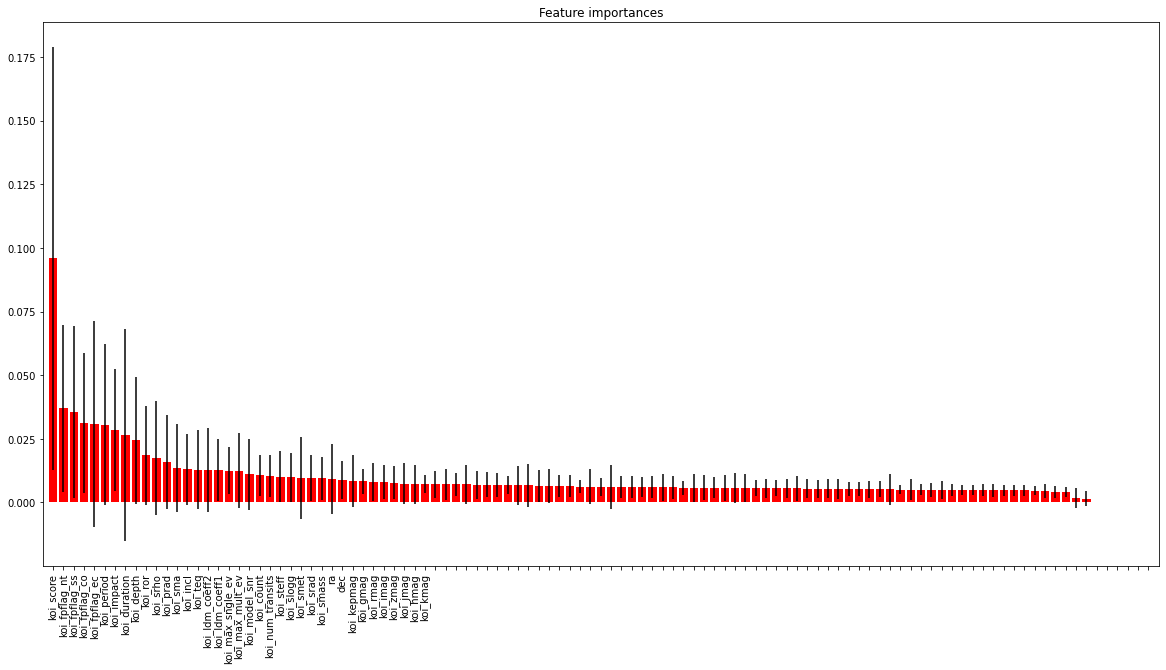

In [71]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1] #reordering features by importance
sorted_importances = [importances[index] for index in indices]
# Print the feature ranking
print("Feature ranking:")


# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), features)
plt.xticks(rotation=90)
plt.xlim([-1,x_train.shape[1]])
plt.show()

In [ ]:
X_train100 = x_train
X_train75 = x_train *.75
X_train50 = x_train *.5
X_train25 = x_train *.25

##Common Functions for Plots and Scores

###*ROC Curves*

In [73]:
def plot_roc_curve(predictions) :
  fpr, tpr, _ = roc_curve(predictions, y_test, drop_intermediate=False)
  plt.figure(figsize=(12,6))
  # Adding the ROC
  plt.plot(fpr, tpr, color='red',
  lw=2, label='ROC curve')
  # Random FPR and TPR
  plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
  # Title and label
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.grid()
  plt.title('ROC curve')
  plt.show()

###*Confusion matrix*

###Printing Scores

In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [75]:
def print_scores(y_pred) :
  	
  print('Precision: %.3f' % precision_score(y_test, y_pred))
  print('Recall: %.3f' % recall_score(y_test, y_pred))
  print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
  print('F1 Score: %.3f' % f1_score(y_test, y_pred))


In [76]:
import os
def plot_confusion_matrix(predictions, model):
  cm = confusion_matrix(predictions, y_test)
  ax = plt.figure(figsize=(12,8))
  path = '/content/drive/MyDrive/Exoplanet Detection/Figures'
  title = "Confusion Matrix For "  + model + '.png'
  titleCM = "Confusion Matrix For "  + model
  pathmain = os.path.join(path, title)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cm.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cm.flatten()/np.sum(cm)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  ax = sns.heatmap(cm ,annot = labels, fmt = '',cmap = 'Blues')
  ax.set_title(titleCM, fontdict = {'weight' : 'bold', 'size' : '16'})
  # classification report
  ax.figure.savefig(pathmain)
  cr = classification_report(predictions, y_test)
  print(cr)

#Logistic Regression

In [77]:
def grid_plot(x, y, x_label, title, y_label='cross_val, accuracy'):  
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    # x - the number of neighbors, y - accuracy
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [78]:
grid={"C": np.logspace(-2, 4, 20), "penalty":["l2"] }

logreg = LogisticRegression(max_iter=1000)
logreg_cv = GridSearchCV(logreg, grid, cv=5)

# learning
logreg_cv.fit(x_train, y_train)

logreg_cv.best_params_, logreg_cv.best_score_


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


({'C': 3.359818286283781, 'penalty': 'l2'}, 0.8773999187931606)

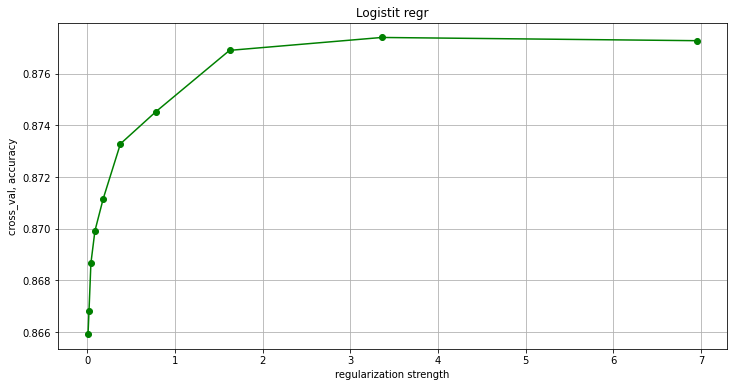

In [79]:
grid_plot(logreg_cv.cv_results_['param_C'][:10], logreg_cv.cv_results_['mean_test_score'][:10], 'regularization strength', 'Logistit regr')

In [80]:
predictions = logreg_cv.predict(x_test)
predictions

array([1, 0, 1, ..., 0, 1, 1])

##PLotting the ROC Curve

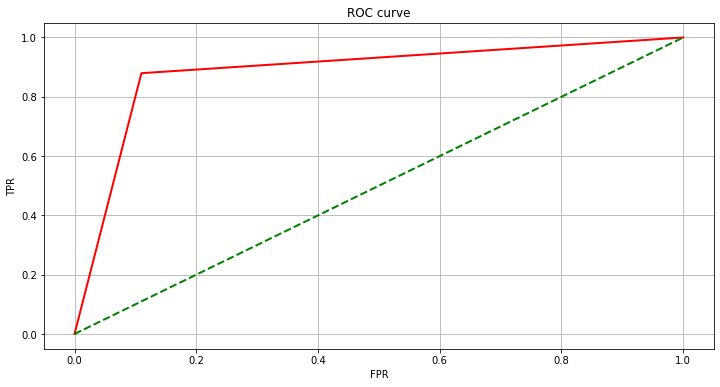

In [81]:
plot_roc_curve(predictions=predictions)

##Confusion Matrix

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       719
           1       0.89      0.88      0.88       697

    accuracy                           0.88      1416
   macro avg       0.88      0.88      0.88      1416
weighted avg       0.88      0.88      0.88      1416



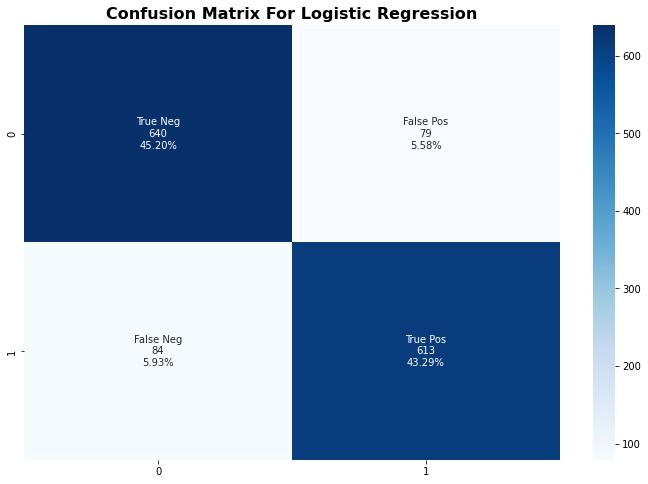

In [82]:
plot_confusion_matrix(predictions, "Logistic Regression")

##Scores

In [83]:
print_scores(predictions)

Precision: 0.879
Recall: 0.886
Accuracy: 0.885
F1 Score: 0.883


#KNN

In [84]:
from sklearn.neighbors import KNeighborsClassifier

# We initialize the algorithm
knn = KNeighborsClassifier()

estimator_KNN = KNeighborsClassifier(algorithm='auto')
parameters_KNN = {
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
}
                   
# with GridSearch
gs_knn = grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

# We train the model
gs_knn.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': (20, 40, 1),
                         'metric': ('minkowski', 'chebyshev'),
                         'n_neighbors': (1, 10, 1), 'p': (1, 2),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy')

###Best Params

In [85]:
print("\n The best score across ALL searched params:\n",gs_knn.best_score_)
print("\n The best parameters across ALL searched params:\n",gs_knn.best_params_)


 The best score across ALL searched params:
 0.8545776077585201

 The best parameters across ALL searched params:
 {'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


##Prediction

In [86]:
predictions_knn = gs_knn.predict(x_test)
predictions_knn

array([0, 0, 1, ..., 0, 1, 1])

##Plotting the ROC Curve

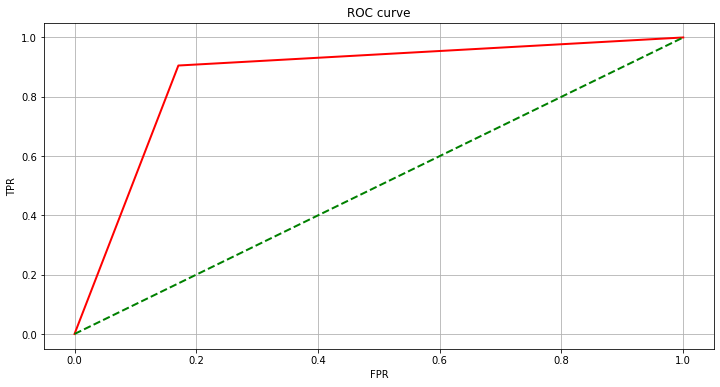

In [87]:
plot_roc_curve(predictions=predictions_knn)

##Confusion Matrix

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       803
           1       0.80      0.91      0.85       613

    accuracy                           0.86      1416
   macro avg       0.86      0.87      0.86      1416
weighted avg       0.87      0.86      0.86      1416



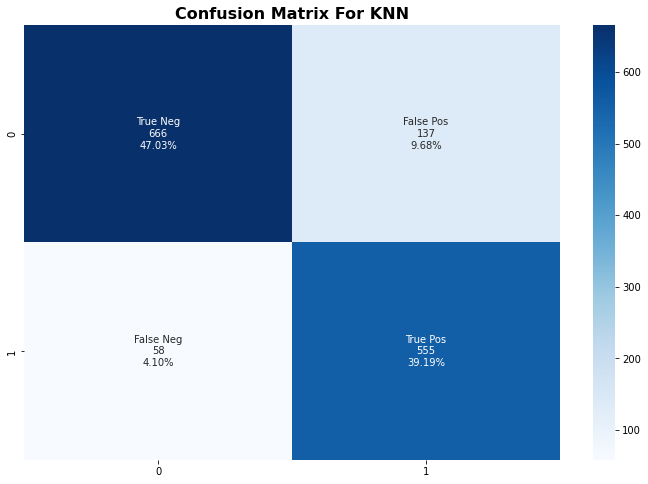

In [88]:
plot_confusion_matrix(predictions=predictions_knn, model= "KNN")

#Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc=RandomForestClassifier(random_state=42)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}                 
# with GridSearch
gs_rf = RandomizedSearchCV(rfc, param_grid, scoring='average_precision', cv=5, random_state=10)

# We train the model
gs_rf.fit(x_train, y_train)

In [ ]:
print("\n The best score across ALL searched params:\n",gs_rf.best_score_)
print("\n The best parameters across ALL searched params:\n",gs_rf.best_params_)

In [ ]:
prediction = gs_rf.predict(x_test)
prediction

In [ ]:
plot_roc_curve(prediction)

In [ ]:
plot_confusion_matrix(prediction, "Random Forest")

#SVM

In [ ]:
from sklearn.svm import SVC 

In [ ]:
c_space = [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]
gamma_space = [1e-2, 1e-3, 1e-4, 1e-5]
kernels = ['rbf', 'linear', 'sigmoid']
svm_param_grid = {'SVM__C': c_space, 'SVM__gamma': gamma_space, 'SVM__kernel': kernels}

gs_svc = GridSearchCV(
    estimator=SVC(),
    param_grid=svm_param_grid,
    n_jobs = -1,
    cv = 5, verbose = 3
)

# We train the model
gs_svc.fit(x_train, y_train)             


In [ ]:
print("\n The best score across ALL searched params:\n",gs_svc.best_score_)
print("\n The best parameters across ALL searched params:\n",gs_svc.best_params_)

In [ ]:
prediction = gs_rf.predict(x_test)
prediction